In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Set a nice style for plots immediately
plt.style.use('dark_background')

In [2]:
class TalentAnalyzer:
    def __init__(self, file_path):
        try:
            self.df = pd.read_csv(file_path)
            self.df.columns = self.df.columns.str.strip() # Clean messy headers
            print(f"Data loaded successfully: {self.df.shape[0]} rows found.")
        except FileNotFoundError:
            print("Error: File not found.")
            self.df = None

    def preprocess_data(self):
        # 1. Handle 'batter' vs 'batsman' naming issues
        col = 'batter' if 'batter' in self.df.columns else 'batsman'
        
        # 2. Group by player and aggregate stats
        stats = self.df.groupby(col).agg({
            'batsman_runs': 'sum',
            'ball': 'count',
            'match_id': 'nunique'
        }).reset_index()
        
        # 3. Rename column to standard 'batsman'
        stats.rename(columns={col: 'batsman'}, inplace=True)
        
        # 4. Filter: Only keep experienced players (>300 balls)
        self.player_stats = stats[stats['ball'] > 300].copy()
        return self.player_stats

    def feature_engineering(self):
        # Create metrics: Consistency (Avg) and Velocity (Strike Rate)
        self.player_stats['Avg_Runs'] = self.player_stats['batsman_runs'] / self.player_stats['match_id']
        self.player_stats['Strike_Rate'] = (self.player_stats['batsman_runs'] / self.player_stats['ball']) * 100

    def run_clustering(self, n_clusters=4):
        X = self.player_stats[['Avg_Runs', 'Strike_Rate']]
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        self.player_stats['Cluster'] = kmeans.fit_predict(X)

    def visualize(self):
        plt.figure(figsize=(10, 6))
        plt.scatter(self.player_stats['Avg_Runs'], self.player_stats['Strike_Rate'], 
                   c=self.player_stats['Cluster'], cmap='rainbow', s=100, alpha=0.8)
        
        plt.title('Player Performance Clusters', fontsize=14, color='yellow')
        plt.xlabel('Consistency (Avg Runs)', fontsize=12)
        plt.ylabel('Velocity (Strike Rate)', fontsize=12)
        plt.grid(True, alpha=0.2)
        
        # Save explicitly with black background
        plt.savefig('sde_project_result.png', facecolor='black')
        print("Graph saved as 'sde_project_result.png'")
        plt.show()

In [3]:
# Initialize the engine
file_path = r"C:\Users\Windows 10\Downloads\deliveries_2008-2024.csv"
engine = TalentAnalyzer(file_path)

# SANITY CHECK: Look at the raw data
if engine.df is not None:
    display(engine.df.head(3))

Data loaded successfully: 260920 rows found.


,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NA,NA,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,,0,NA,NA,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NA,NA,NaN


In [4]:
# Run the cleaning and aggregation
df_players = engine.preprocess_data()

# CHECK: How many qualified players do we have?
print(f"Qualified Players (Min 300 balls): {len(df_players)}")
display(df_players.head())

Qualified Players (Min 300 balls): 173


,batsman,batsman_runs,ball,match_id
1,A Badoni,634,505,35
10,A Mishra,381,440,55
17,A Symonds,974,781,36
30,AB de Villiers,5181,3487,170
32,AC Gilchrist,2069,1555,80


In [5]:
# Calculate the advanced stats
engine.feature_engineering()

# CHECK: Do the numbers look realistic?
# Showing top 5 players by Strike Rate to verify logic
display(engine.player_stats.sort_values(by='Strike_Rate', ascending=False).head(5))

,batsman,batsman_runs,ball,match_id,Avg_Runs,Strike_Rate
433,PD Salt,653,385,21,31.095238,169.610390
617,TM Head,772,458,25,30.880000,168.558952
39,AD Russell,2488,1515,104,23.923077,164.224422
208,H Klaasen,993,613,32,31.031250,161.990212
612,TH David,659,417,35,18.828571,158.033573


In [6]:
# Train the Machine Learning model
engine.run_clustering(n_clusters=4)

# CHECK: How many players in each group?
print("Player count per Cluster:")
print(engine.player_stats['Cluster'].value_counts().sort_index())

Player count per Cluster:
Cluster
0    76
1    48
2    25
3    24
Name: count, dtype: int64


Graph saved as 'sde_project_result.png'


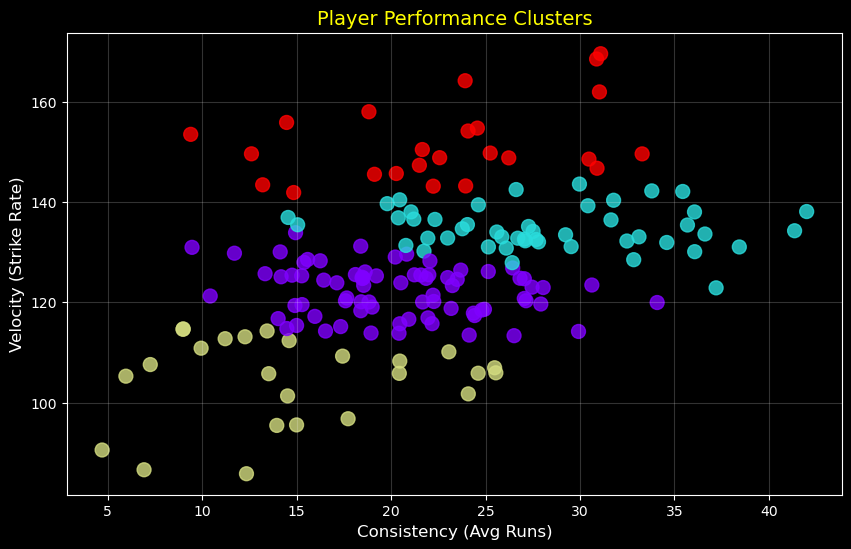

In [7]:
# Generate the report
engine.visualize()